In [4]:
# Data
from sklearn.datasets import make_blobs

X, y = make_blobs(1000, centers = 3, cluster_std=1., random_state=1)
X.shape, y.shape

((1000, 2), (1000,))

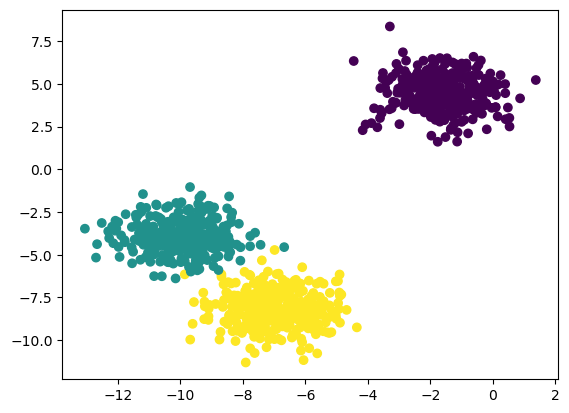

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c= y)

In [6]:
# Train / Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 2), (800,), (200, 2), (200,))

In [7]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(1)
device = "cpu"

In [8]:
# Dataset
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).long()  # !!!!!!!!
        
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

    def __len__(self):
        return len(self.data)
    
train_dataset = MyDataset(X_train, y_train)
len(train_dataset)

800

In [9]:
# Train/Val split
from torch.utils.data.dataset import random_split
train_dataset, val_dataset = random_split(train_dataset, [600, 200])
len(train_dataset), len(val_dataset) # after train/val split

(600, 200)

In [10]:
# DataLoader
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=20)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [11]:
# Model

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )
    
    def forward(self, x):
        out = self.layer(x)
        return out

In [12]:
model = MyModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = .1)

In [13]:
def accuracy_fn(y_pred, y_true): # the inputs are tensors
    corrects = torch.eq(y_pred, y_true).sum().item()
    return corrects / len(y_pred) * 100

In [14]:
# Training Loop
n_epochs = 100
train_losses = []
train_accs = []
for e in range(n_epochs):
    model.train()
    loss_train = 0
    acc_train = 0
    # Train Batches Loop
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch) # batch_size * n_classes (20 * 3)
        loss = loss_fn(y_logits, y_batch)
        
        y_hat = torch.softmax(y_logits, dim=1) # From logits to probs
        y_pred = torch.argmax(y_hat, dim = 1) # from probs to labels
        acc_train += accuracy_fn(y_pred, y_batch)
        
        loss_train = loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_train /= len(train_loader)
    acc_train /= len(train_loader)
    
    train_losses.append(loss_train)
    train_accs.append(acc_train)
        
    # Val Batches Loop

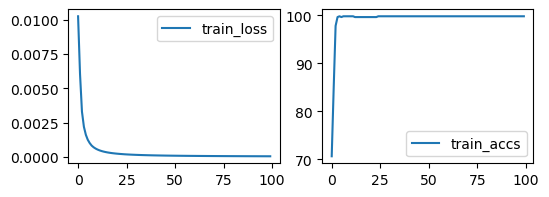

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (6, 2))
ax[0].plot(train_losses, label = "train_loss")
# ax[0].plot(val_losses,  label="val loss");
ax[0].legend()

ax[1].plot(train_accs, label = "train_accs")
# ax[1].plot(val_accs,  label="val accs");
ax[1].legend()

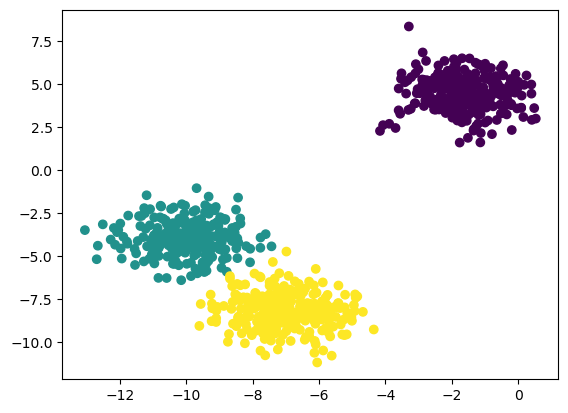

In [16]:
X_train_tensor = torch.from_numpy(X_train).float()
y_logits = model(X_train_tensor)
y_hat = torch.softmax(y_logits, dim = 1)
y_pred = torch.argmax(y_hat, dim = 1)

plt.scatter(X_train[:, 0], X_train[:, 1], c = y_pred)